# Ensemble Learning through Pasting

$\implies$  hyperparam = M = #learners

bc data is split in M distinct subsets on which each learner is trained

Ofc the optimal M will depend on the size of the trainset as you are making a bias-variance tradeoff which largely depends on the datasize

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
## ENSMBLE

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [4]:
np.random.seed(2020)

In [5]:
N_train = 2000
N_test = 100000
d = 1
T = 2

In [6]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [7]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [8]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [9]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07889893198941902

In [10]:
# 
def Flatten_Training_Sample(X , f):
    return np.array([f(x) for x in X])
#Shape of each sample j: [X_j[0,0],... ,X_j[d,0],...,X_j[0,T] , ..., X_j[d,T]]
Flatten_X_1_train = Flatten_Training_Sample(X_train, lambda x : x.T.flatten())
Flatten_X_1_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())


## Create Custom Models
(to have more control of splitting etc)

In [15]:
from sklearn.base import clone, BaseEstimator

class BaggingBaseClass(BaseEstimator):
    def __init__(self,M,predictor):
        super().__init__()
        self.M = M
        self.predictor = predictor
        self.predictors = None
        
    def _split_train_set(self,X,y):
        raise NotImplementedError
    
    def fit(self,X,y):
        print("fit")
        print(X.shape)
        self.predictors  = [clone(self.predictor)] *self.M
        X_list,y_list = self._split_train_set(X,y)
        for i in range(self.M):
            self.predictors[i].fit(X_list[i],y_list[i])
    
    def predict(self,X):
        print("predict")
        print(X.shape)
        predictions = np.zeros((X.shape[0]))
        for i in range(self.M):
            predictions = predictions + self.predictors[i].predict(X)
        predictions = predictions / self.M 
        return predictions

class SimplePaster(BaggingBaseClass):
    def __init__(self,M,predictor):
        super(SimplePaster,self).__init__(M,predictor)
    
    def _split_train_set(self,X,y):
        n = X.shape[0]// self.M
        X_list = []
        y_list = []
        for i in range(self.M-1):
            X_list.append(X[n*i:n*(i+1)])
            y_list.append(y[n*i:n*(i+1)])
        X_list.append(X[(self.M-1)*n:])
        y_list.append(y[(self.M-1)*n:])
        return X_list, y_list
    
s = SimplePaster(11,None)
s.get_params()

{'M': 11, 'predictor': None}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# this one could be used in GridSearches 
def create_scorer(V_0):
    def normalized_error_VT(y_hat,y):
            #y_hat= f_X predicted
            # y = V_T = f_X
            Normalized_Error_T = np.sqrt(1/len(y)*np.sum((y_hat-y)**2, axis=0))/V_0
            ## see formula p4 for ||f(X)||2,Q t
            ## since samples are drawn according to measure - just sum them up
            return Normalized_Error_T
    return normalized_error_VT

def normalized_error_VT(y_hat,y,V_0):
        #y_hat= f_X predicted
        # y = V_T = f_X
        Normalized_Error_T = np.sqrt(1/len(y)*np.sum((y_hat-y)**2, axis=0))/V_0
        ## see formula p4 for ||f(X)||2,Q t
        ## since samples are drawn according to measure - just sum them up
        return Normalized_Error_T


In [21]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

# define your custom function for passing into each thread
def create_logger(m,trial,log):
    def logger(x):
        print(f"{m},{trial} -> {x}")
        log.append([m,trial,x])
    return logger

def calc_normalized_error(m, X_train, y_train, N_test,d, DeltaT, base_model,trial):
    """
    Train given model on given dataset, afterwards create a new test set of size N_test and determine
    the normalized Error
    
    uses:
    - normalized_error_VT
    - Flatten_Training_Sample
    """
    print(f" {m},{trial} -> thread id = {threading.current_thread().ident}")
    model = clone(base_model)
    model.M = m
    model.fit(X_train,y_train)
    s_test = MaxCallStochasticModel(N_test, d, DeltaT)
    s_test.generate_samples()
    y_test = s_test.y
    X_test = s_test.X
    S_test = s_test.S

    Flatten_X_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())

    V_T = y_test  
    V_0 = s_test.generate_true_V(0)
    V_0= V_0.mean()
    y_hat = model.predict(Flatten_X_test)
    error = normalized_error_VT(y_hat,V_T,V_0).item()
    return error

# GRIDSEARCH PARAMS
model = SimplePaster(0,GaussianProcessRegressor(kernel))
trials = 3
M_grid = np.arange(1,8)
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count())
for trial in range(trials):
    for m in M_grid:
        print(m,trial)
        pool.apply_async(calc_normalized_error,
                                             args=(m,Flatten_X_1_train,y_train,N_test,1, [1/12,11/12], model,trial),
                                            callback = create_logger(m,trial,results))
pool.close()
pool.join()

converted_results = np.ones((len(M_grid)+1,trials))*(-1)
for item in results:
    converted_results[item[0],item[1]] = item[2]



1 0
2 1,0 -> thread id = 12892
fit
(500, 2)
 0
3 0
4 0
5 0
6 0
7 0
1 1
2 1
3 1
4 1
5 1
6 1
7 1
1 2
2 2
3 2
4 2
5 2
6 2
7 2
 2,0 -> thread id = 10076 3,0 -> thread id = 7888
fit
(500, 2)

 4,0 -> thread id = 3012
fit
(500, 2)
 5,0 -> thread id = 17028
fit
(500, 2)
fit
(500, 2)
 6,0 -> thread id = 18528
fit
(500, 2)
 7,0 -> thread id = 2160
fit
(500, 2)
 1,1 -> thread id = 8388
fit
(500, 2)
 2,1 -> thread id = 10020
fit
(500, 2)
 3,1 -> thread id = 10596
fit
(500, 2)
 4,1 -> thread id = 8988
fit
(500, 2)
 5,1 -> thread id = 1540
fit
(500, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)predict

(10000, 2)
predict
(10000, 2)
 6,1 -> thread id = 83881,1 -> 0.5450642612553479

fit
 7,1 -> thread id = 12892
(500, 2)1,0 -> 0.5848650017409222
fit

(500, 2)
 1,2 -> thread id = 10076predict

(10000, 2)
fit2,0 -> 0.3177009248103332

(500, 2)
 2,2 -> thread id = 100202,1 -> 0.3905129931282453
fit

(500, 2)
 3,2 -> thread id = 78883,0 -> 0.4634411340084294
fit

(500, 2)
 4,2 -> thread id = 10596
fit
(500, 2)
3,1 -> 0.4474797757485245
 5,2 -> thread id = 30124,0 -> 0.5465856506420643

fit
(500, 2)
 6,2 -> thread id = 2160
fit
(500, 2)7,0 -> 0.2829314008605058

 7,2 -> thread id = 15405,1 -> 0.2788834881142818

fit
(500, 2)
5,0 -> 0.27824503966605063
4,1 -> 0.4964119219423114
6,0 -> 0.2978995551154866


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
predict
(10000, 2)
1,2 -> 0.5310035948557245
2,2 -> 0.4306583657922306
3,2 -> 0.418944590413394
6,2 -> 0.2636764170737784
7,2 -> 0.239147527579951
4,2 -> 0.5721391218986948
5,2 -> 0.2742002237744242
7,1 -> 0.20762926110266072
6,1 -> 0.2733087670752447


In [18]:
print(converted_results)


[[-1.         -1.         -1.        ]
 [ 0.55899989  0.54485326  0.54674926]
 [ 0.38531225  0.33559481  0.40713421]
 [ 0.40523231  0.4575702   0.44414618]
 [ 0.50339397  0.58262174  0.49286641]
 [ 0.28899772  0.28136636  0.2957769 ]
 [ 0.26754352  0.28982683  0.26176798]
 [ 0.23950294  0.25338229  0.28614326]]


In [19]:
masked_results= np.ma.masked_where(converted_results[1:] <= 0.0,converted_results[1:]) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=1)
sigmas = masked_results.std(axis=1)


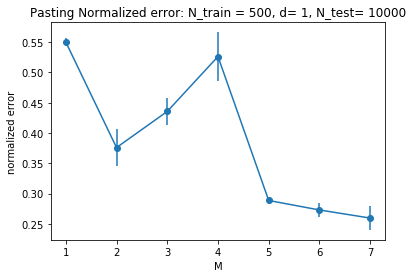

In [20]:
plt.errorbar(np.array(M_grid),means,sigmas,marker ='o')
plt.title(f"Pasting Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.ylabel("normalized error")
plt.show()

**bottom line: Pasting is not interesting and is hard to quantify as it's results depend very strongly on the size of the dataset**
